#### Import some basic libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
%matplotlib inline
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Wine Quality Data

The UCI wine quality dataset uses  Portuguese "Vinho Verde" wine data to provide both classification and regression machine learning tasks. Users can attempt to classify wines as red/white, or predict the overall quality of wine.

The variables included in this dataset include:   
Input variables (based on physicochemical tests):    
1 - fixed acidity    
2 - volatile acidity    
3 - citric acid    
4 - residual sugar    
5 - chlorides    
6 - free sulfur dioxide    
7 - total sulfur dioxide    
8 - density    
9 - pH    
10 - sulphates    
11 - alcohol    

Output variable (based on sensory data):    
12 - quality (score between 0 and 10)   


Citation:
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

https://archive.ics.uci.edu/ml/datasets/Wine+Quality

In [11]:
def obtain_data():

    df_red = pd.read_csv(r'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep = ';')
    df_white = pd.read_csv(r'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')
    
    df_white['category'] = 'white'
    df_red['category'] = 'red'
    
    df = pd.concat([df_white, df_red], axis=0)
    
    # remove spaces and replace with underscores
    df.columns = df.columns.str.replace(" ", "_")
    
    del df_white
    del df_red
    
    return df

df = obtain_data()
print (df.head())
print ('\n')
print (df.groupby('category')['pH'].count())

df['acceptable'] = ''
df['acceptable'][df.quality > 5] = 'ok'
df['acceptable'][df.quality <= 5] = 'swill'

df[['red', 'white']] = pd.get_dummies(df['category'])

df.groupby('acceptable')['category'].count()

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality category  
0      8.8        6    white  
1      9.5        6    w

acceptable
ok       4113
swill    2384
Name: category, dtype: int64

In [12]:
def logistic_regression(X, y):

    from sklearn.linear_model import LogisticRegression
    from sklearn import cross_validation as cv
    from sklearn.metrics import classification_report
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score

    # splits data into training and test sets. 70% train, 30% test.
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.3, random_state=0)

    stdsc      = StandardScaler()

    # z-scores training set data, then applies z-score formula from training set to test set.
    # this ensures the training data does not learn anything about the test data.
    X_train    = stdsc.fit_transform(X_train)
    X_test     = stdsc.transform(X_test)

    model      = LogisticRegression()
    model.fit(X_train, y_train)

    # make predictions on the test set. expected = actual risk, predicted = predicted risk, probs = probability of being risky
    expected   = y_test
    predicted  = model.predict(X_test)
    probs      = model.predict_proba(X_test)

    print ('Accuracy Score: %.2f%%' % (accuracy_score(expected, predicted) * 100))
    print (classification_report(expected, predicted))
    
    return X_train, y_train, X_test, y_test,  expected, predicted, probs,  model

In [13]:
predictors = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 
 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'red', 'white']
target = ['acceptable']

In [15]:
from sklearn import cross_validation as cv
X = df[predictors]
y = df[target]


X_train, y_train, X_test, y_test, expected, predicted, probs,  model = logistic_regression(X, y)

Accuracy Score: 73.69%
             precision    recall  f1-score   support

         ok       0.76      0.85      0.80      1215
      swill       0.69      0.56      0.62       735

avg / total       0.73      0.74      0.73      1950



In [16]:
def create_accuracy_report(probs, predicted, expected, nbins):
    
    # obtain unique list of classes
    classes = list(np.unique(expected))
    #add p() around class name to indicate probability of
    prob_cols = ['p(' + s + ')' for s in classes]
    
    # combine outputs from classifier
    probabilities = pd.DataFrame(probs, columns = prob_cols)
    predictions = pd.DataFrame(predicted, columns = ['prediction'])
    expect = pd.DataFrame(expected)
    expect.columns = ['category']
    expect = expect.reset_index(drop=True)
    df_report = pd.concat([probabilities, predictions, expect], axis=1)
    df_report = df_report.reset_index(drop=True)
    
    # create dummy 1 and 0 variables for category
    df_report[classes] = pd.get_dummies(df_report['category'])
    
    bins = np.linspace(0,1,nbins+1)
    df_report[prob_cols] = np.digitize(df_report[prob_cols],bins)
    
    return df_report


def summarize_report(df_report):
    
    classes = np.unique(df_report['category'])
    
    df = pd.DataFrame()
    for x in classes:
        
        avg   = df_report.groupby('p(' + str(x) + ')')[x].mean()
        count = df_report.groupby('p(' + str(x) + ')')[x].count()
        
        df_temp = pd.concat([avg, count], axis=1)
        cols = ['avg_' + str(x), 'count_' + str(x)]
        df_temp.columns = cols
        df = pd.concat([df, df_temp], axis=1)
    
    return df



In [17]:
df_summary

,avg_ok,count_ok,avg_swill,count_swill
1,0.200000,20,0.083333,312
2,0.171875,64,0.140000,350
3,0.254777,157,0.255556,270
4,0.300546,183,0.355000,200
5,0.448276,174,0.500000,220
6,0.500000,220,0.551724,174
7,0.645000,200,0.699454,183
8,0.744444,270,0.745223,157
9,0.860000,350,0.828125,64
10,0.916667,312,0.800000,20


In [61]:
def create_bin_labels(nbins):
    
    labels = []
    for x in range(nbins):
        bottom = (x*(1 / nbins))
        top = ((x+1)*(1/ nbins))
        label = '%.2f - %.2f' % (bottom, top)
        labels.append(label)
        
    return labels
    

def create_prediction_accuracy_fig(probs, predicted, expected, nbins=10):

    
    df_report = create_accuracy_report(probs, predicted, expected, nbins)
    df_summary = summarize_report(df_report)
    
    yticklabels = np.array(create_bin_labels(nbins))
    yticklabels = np.array(yticklabels)
    y_pos = np.arange(len(yticklabels))

    fig, ax = plt.subplots(nrows=len(classes),ncols=2)

    for x, class_name in enumerate(classes):
        
        # replace with a numpy command
        bars = np.array(df_summary['avg_' + str(class_name)])
        observations = np.array(df_summary['count_' + str(class_name)])

        ax[x,0].barh(y_pos,  bars)
        ax[x,0].set_yticks(y_pos)
        ax[x,0].set_yticklabels(yticklabels)
        ax[x,0].set_xticks(np.arange(0,1.1,.1))
        ax[x,0].set_ylabel('predicted probability')
        ax[x,0].set_xlabel('actual probability')

        ax[x,0].spines["top"].set_visible(False) 
        ax[x,0].spines["right"].set_visible(False)
        ax[x,0].set_title('accuracy of class %s' % str(class_name))

        ax[x,1].barh(y_pos, observations, height=1, alpha=.5)
        ax[x,1].spines['top'].set_visible(False)
        ax[x,1].spines['bottom'].set_visible(False)
        ax[x,1].spines['right'].set_visible(False)
        ax[x,1].spines['left'].set_visible(False)    
        ax[x,1].axes.yaxis.set_ticklabels([])
        ax[x,1].axes.xaxis.set_ticklabels([])
        ax[x,1].xaxis.set_ticks_position('none') 
        ax[x,1].yaxis.set_ticks_position('none')
        ax[x,1].set_title('distributions of predictions for class %s' % str(class_name))

    fig.set_figheight(5 * len(classes))
    fig.set_figwidth(14)

    return fig

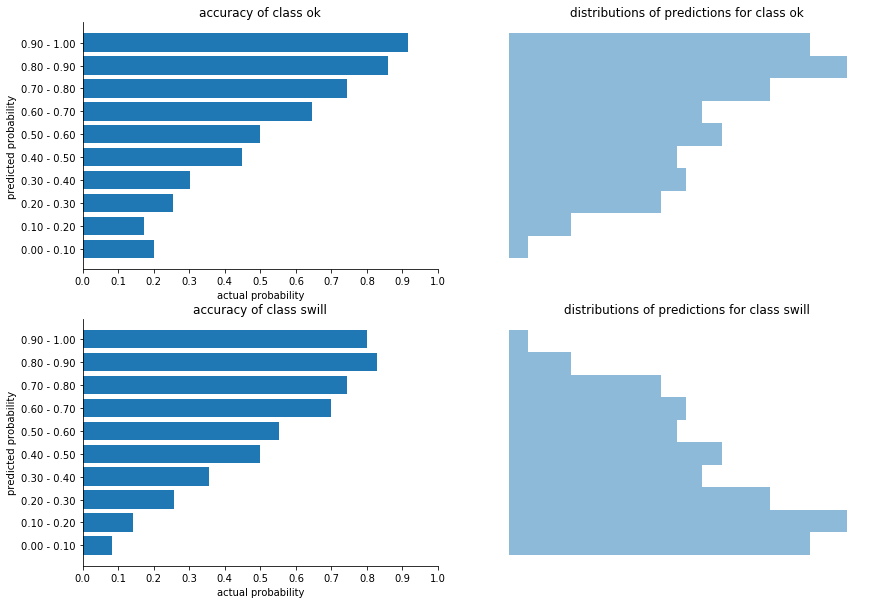

In [66]:
fig = create_prediction_accuracy_fig(probs, predicted, expected, nbins=10)